## 为什么要使用Deep-Q-Learning
- Q-Learning算法中，我们用表格来存储action value Q(s,a)。但这种方法只适用于state和action都是离散的，而且空间都比较小的情况
- DQN算法，则用function approximation，来估计Q值（虽然有一定的精度损失），这样可以处理state时连续的，action是离散的情况

## DQN流程
- 核心思想： 训练一个神经网络（训练网络Q）去近似**状态-动作值函数**Q(s,a)
1. **初始化**
   - 初始化 训练网络 \( Q(s,a) \) 与目标网络 \( Q'(s,a) \)
   - 初始化经验回放池 `ReplayBuffer`

2. **对每个回合（Episode）重复**
   1. 从环境中重置初始状态 \( s_0 \)
   2. 在每一步中：
      - 使用 **ε-greedy 策略** 选择下一步动作：
        - 以概率 ε 随机选择动作（探索）
        - 以概率 1−ε 选择action value最大的动作，通过目标网络拟合action values（利用）
      - 执行动作 \( a_t \)，获得下一state \( s_{t+1} \) 和reward \( r_t \)
      - 将转移样本 `(s_t, a_t, r_t, s_{t+1}, done)` 存入经验池

3. **从经验回放池中随机采样一批样本**
$$
(s,a,r,s',done)
$$

4. **通过目标网络Q' 计算目标 Q 值（TD Target）**

$$
y = r + \gamma \max_{a'} Q'(s',\, a';\, w')
$$

5. **计算损失并更新网络参数**
   $$
   L = \left( y - Q(s,a;w) \right)^2
   $$
   通过反向传播最小化损失 \( L \)

6. **周期性地更新目标网络**
   $$
   w'- \leftarrow w
   $$

7. **重复以上步骤，直到收敛或达到最大回合数**

---

### ⚙️ 关键技巧
- **Experience Replay（经验回放）**  
  打破样本间的相关性，提高训练稳定性。
- **Target Network（目标网络）**  
  固定目标 Q 网络参数一段时间再更新，防止训练震荡。
- **ε-Greedy 策略**  
  在探索与利用之间平衡。

In [1]:
import random
import gymnasium as gym
import numpy as np
import collections
import torch
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # 解决plt.show 报错问题

In [2]:
class ReplayBuffer:
    '''
    经验回放池:
        用来保存智能体以前经历过的 (state, action, reward, next state)，然后在训练时随机抽取旧的经验出来学习(uniform distribution)。
        在强化学习中，智能体是按时间顺序学习的：第 1 步 → 第 2 步 → 第 3 步……
        如果直接用最新的经验去训练神经网络，会有两个问题：
            1. 样本之间强相关（都来自相邻时间步）→ 训练会不稳定、容易震荡。
            2. 旧经验会被忘记→ 学习不到长期规律。
        ReplayBuffer的作用就是打破时间相关性，让样本更独立同分布(i.i.d.)，并且让智能体能多次利用旧经验。
    '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity) # 双端队列，先进先出, 超出maxlen时，自动删除最早的元素
    
    def add(self, state, action, reward, next_state, done): # 添加经验
        self.buffer.append((state, action, reward, next_state, done)) # done是一个布尔值，True表示到达episode终点
    
    def sample(self, batch_size): # 随机抽取旧的经验供训练（uniform distribution)
        transitions = random.sample(self.buffer, batch_size) # 从buffer中随机抽取batch_size个经验
        state, action, reward, next_state, done = zip(*transitions) # 解压
        return np.array(state), action, reward, np.array(next_state), done
    '''为什么要解压？
    transitions =
    [
        (s1, a1, r1, s1_next, done1),
        (s2, a2, r2, s2_next, done2),
        (s3, a3, r3, s3_next, done3)
    ]
    而我们需要的格式是：
    state = ([1,2], [2,3], [3,4])
    action = (0, 1, 0)
    reward = (1, 1, -1)
    next_state = ([1,3], [2,4], [3,5])
    done = (False, False, True)

    为什么要用np.array()？
    因为state和next_state是tuple，里面每一个元素是list，不是矩阵格式，np.array()可以把它们转换成矩阵格式，
    而神经网络训练时要求使用矩阵格式的数据。
    '''
    def size(self): # 目前buffer中数据的数量
        return len(self.buffer)

In [3]:
class Qnet(torch.nn.Module): # Qnet是继承自 torch.nn.Module，是一个神经网络模型类
    def __init__(self, state_dim, hidden_dim, action_dim):
        '''只有一层隐藏层的Q网络'''
        super(Qnet, self).__init__() #调用父类（也就是 torch.nn.Module）的初始化方法，不然创造的Qnet无法使用父类的方法
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim) # 全连接层
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim) # 输出层

    def forward(self, x): # 前向传播
        x = F.relu(self.fc1(x)) # 激活函数ReLU
        return self.fc2(x) # 输出层

In [4]:
class DQN:
    '''DQN算法'''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update, device):
        self.device = device # 设备（GPU/CPU）
        self.action_dim = action_dim # 动作维度
        self.q_net = Qnet(state_dim, hidden_dim, action_dim).to(self.device) # 训练网络
        self.target_q_net = Qnet(state_dim, hidden_dim, action_dim).to(self.device) # 目标网络
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate) # 优化器，Adam算法

        self.gamma = gamma # 折扣因子
        self.epsilon = epsilon # ε-贪婪算法
        self.target_update = target_update # 目标网络更新频率
        self.count = 0 # 记录步数，记录与环境交互的总步数

    def take_action(self, state):
        '''根据训练网络近似Q(s,a)，使用ε-贪婪算法选择动作a'''
        if np.random.random() < self.epsilon:  # 所以ε越小，探索越少，利用越多
            action = np.random.randint(self.action_dim) # 探索：随机选择动作
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device) # 转换成张量，并添加一个维度用于存放batch_size
            action = self.q_net(state).argmax().item() # 将state张量输入训练网络，得到Q值最大的动作
        return action

    def update(self, transition_dict):
        '''使用经验回放池中的一批经验，更新训练网络'''
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device) # view(-1, 1)将actions转换成列向量
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device) # view(-1, 1)转换成列向量
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device) # view(-1, 1)转换成列向量

        # 使用训练网络计算当前Q值
        q_values = self.q_net(states).gather(1, actions) # gather()根据actions索引，选出对应的Q值

        # 使用目标网络计算目标Q值（y值）
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1) #使用目标网络计算的下一个状态的最大Q值
        target_q_values = rewards + self.gamma * max_next_q_values * (1 - dones) # 如果done是True，说明到达终点，不需要加上折扣后的下一个状态的Q值

        # 计算损失函数
        loss = torch.mean(F.mse_loss(q_values, target_q_values)) # 均方误差损失函数（当前Q值和目标Q值的差距）

        # 优化训练网络
        self.optimizer.zero_grad() # PyTorch默认梯度累积，这里梯度清零
        loss.backward() # 反向传播
        self.optimizer.step() # 更新参数

        # 每隔target_update步，将训练网络的参数复制到目标网络
        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict()) # load_state_dict()将一个网络的参数加载到另一个网络中
        self.count += 1
    



In [5]:
'''开始训练'''
def train():
    env_name = 'CartPole-v0' # 环境名称
    env = gym.make(env_name) # 创建环境

    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)
    env.action_space.seed(0)

    # 超参数
    learning_rate = 1e-3
    num_episodes = 500 # 最大训练回合数
    hidden_dim = 128 
    gamma = 0.98
    epsilon = 0.1
    target_update = 10 # 目标网络更新频率
    buffer_size = 10000 # 经验回放池大小
    minimal_size = 1000 # 经验回放池中最少的经验数量，达到这个数量后才开始从中采样经验进行训练
    batch_size = 64 # 每次从经验回放池中采样的经验数量
    state_dim = env.observation_space.shape[0] # 状态维度
    action_dim = env.action_space.n # 动作维度
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # 设备（GPU/CPU）

    replay_buffer = ReplayBuffer(buffer_size) # 创建经验回放池
    dqn_agent = DQN(state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update, device) # 创建DQN智能体

    return_list = [] # 用于保存每个回合的奖励总和

    for i in range(10): # 每10个回合tqdm打印一次平均奖励
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0 # 每个回合的奖励总和
                state, _ = env.reset(seed=0) # 重置环境，返回初始状态
                done = False
                while not done:
                    action = dqn_agent.take_action(state) # 根据当前状态选择动作（ε-贪婪算法）
                    next_state, reward, terminated, truncated, info = env.step(action) # 与环境交互，获得next state, reward, 是否任务结束（比如杆子倒了），是否被强制终止（比如步数到了）
                    done = terminated or truncated
                    replay_buffer.add(state, action, reward, next_state, done) # 将经验添加到经验回放池
                    state = next_state
                    episode_return += reward
                    '''当buffer超过minimal_size时，才开始从中采样经验对训练网络进行训练'''
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size) # 从经验回放池中采样一批经验
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'rewards': b_r,
                            'next_states': b_ns,
                            'dones': b_d
                        }
                        dqn_agent.update(transition_dict) # 使用采样的经验对训练网络进行训练
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0: # 每10个回合打印一次平均奖励
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10*i + i_episode + 1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    
    '''图表展示'''
    episode_list = list(range(len(return_list)))
    plt.plot(episode_list, return_list)
    plt.xlabel('Episode')
    plt.ylabel('Return')
    plt.title('DQN on {}'.format(env_name))
    plt.show()

    mv_return = rl_utils.moving_average(return_list, 9) # 计算滑动平均值，窗口大小为9
    plt.plot(episode_list, mv_return)
    plt.xlabel('Episode')
    plt.ylabel('Return')
    plt.title('DQN on {}'.format(env_name))
    plt.show()
        

C:\Users\22688\AppData\Roaming\Python\Python313\site-packages\gymnasium\envs\registration.py:512: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\22688\AppData\Local\Temp\ipykernel_27704\240474614.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  state = torch.tensor([state], dtype=torch.float).to(self.device) # 转换成张量，并添加一个维度用于存放batch_size
Iteration 9: 100%|██████████| 50/50 [00:42<00:00,  1.16it/s, episode=500, return=200.000]


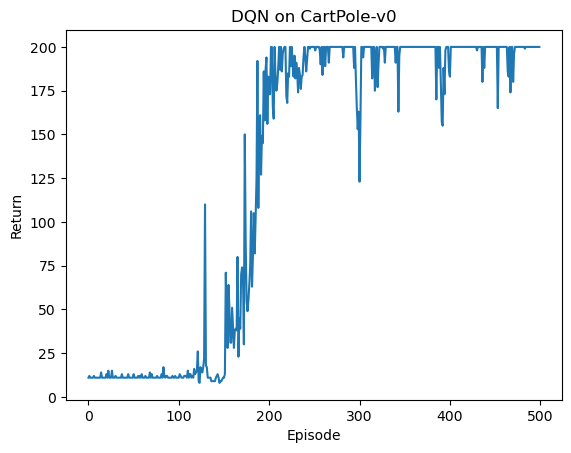

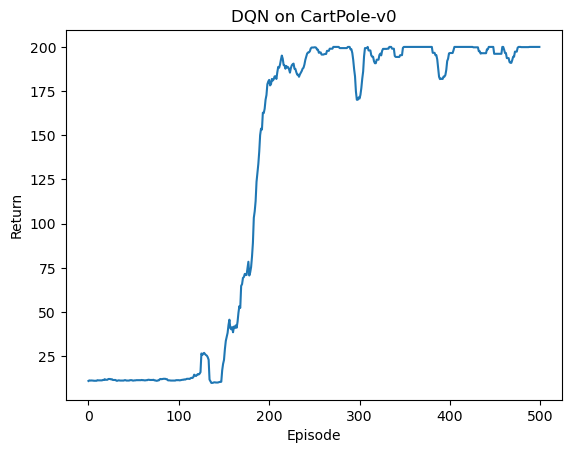

In [ ]:
if __name__ == '__main__':
    train()